In [14]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC


from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, f1_score

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.pipeline import Pipeline

from collections import Counter
import matplotlib.pyplot as plt

import joblib

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import preprocessing_utils as preproc
from preprocessing_utils import generate_recurrence_labels
import config

In [15]:
# Loading in the mRNA and clinical data:
clinical_df = pd.read_csv("../ucec_tcga_pan_can_atlas_2018\data_clinical_patient.txt", sep="\t", comment="#", low_memory=False)
clinical_df = clinical_df.set_index('PATIENT_ID')

mrna_df = pd.read_csv("../ucec_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep="\t", comment="#")

# There are 527 patients in the mRNA and 529 patients in the clinical data

# The first 2 columns of the mRNA data are labels (Hugo_Symbol then Entrez_Gene_Id). 
# 13 of the genes do not have Hugo_symbols, so for these I will you the Entrex_Gene_Id as the label.
missing_symbols = mrna_df['Hugo_Symbol'].isnull()
mrna_df.loc[missing_symbols, 'Hugo_Symbol'] = mrna_df.loc[missing_symbols, 'Entrez_Gene_Id'].astype(str)

# There are 7 rows that have both the same Hugo_Symbol and Entrez_Gene_Id but different values for the patients.
# I will rename these rows to have unique labels by appending -1-of-2 and -2-of-2 to the Hugo_Symbol.
# Get value counts
counts = mrna_df['Hugo_Symbol'].value_counts()

# Generate unique labels for duplicates
def label_duplicates(value, index):
    if counts[value] == 1:
        return value  # Keep unique values unchanged
    occurrence = mrna_df.groupby('Hugo_Symbol').cumcount() + 1  # Count occurrences per group
    return f"{value}-{occurrence[index]}-of-{counts[value]}"

# Apply the labeling function
mrna_df['Hugo_Symbol'] = [label_duplicates(value, idx) for idx, value in mrna_df['Hugo_Symbol'].items()]

mrna_df = mrna_df.set_index('Hugo_Symbol')
mrna_df = mrna_df.drop(columns="Entrez_Gene_Id") # removing the label column before I transpose the df
mrna_df= mrna_df.transpose() # now the patients are the index and the genes are the columns
mrna_df.index = [id[:-3] for id in mrna_df.index] # removes extranious -01 so that the patient ids match the clinical data


In [ ]:
labels = generate_recurrence_labels(
    treatment_file=,
    status_file="../ucec_tcga_pan_can_atlas_2018/data_timeline_status.txt",
    clinical_file="../ucec_tcga_pan_can_atlas_2018/data_clinical_patient.txt"
)

clinical_df, mrna_df, labels = preproc.drop_patients_missing_data(clinical_df, mrna_df, labels)

clinical_cols = clinical_df.columns.tolist()
mrna_cols = mrna_df.columns.tolist()
full_df = clinical_df.join(mrna_df, how="inner")

X_train, X_test, y_train, y_test = train_test_split(full_df, labels, test_size=0.2, random_state=config.SEED, stratify=labels)

# these are all DateFrames
print(type(X_train), X_train.shape)
print(type(X_test), X_test.shape)
print(type(y_train), y_train.shape)
print(type(y_test), y_test.shape)

preprocessor = ColumnTransformer(
    transformers=[
        ("clinical", preproc.ClinicalPreprocessorWrapper(
            cols_to_remove=config.CLINICAL_COLS_TO_REMOVE,
            categorical_cols=config.CATEGORICAL_COLS,
            max_null_frac=config.CLINICAL_MAX_NULL_FRAC,
            uniform_thresh=config.CLINICAL_UNIFORM_THRESH
        ), clinical_cols),

        ("mrna", preproc.MrnaPreprocessorWrapper(
            max_null_frac=config.MAX_NULL_FRAC,
            uniform_thresh=config.UNIFORM_THRESHOLD,
            corr_thresh=config.CORRELATION_THRESHOLD,
            var_thresh=config.VARIANCE_THRESHOLD,
            re_run_pruning=config.RE_RUN_PRUNING,
            literature_genes=config.LITERATURE_GENES,
            correlated_genes_path=config.CORRELATED_GENES_PATH,
            use_stability_selection=config.USE_STABILITY_SELECTION,
            n_boots=config.N_BOOTS,
            fpr_alpha=config.FPR_ALPHA,
            stability_threshold=config.STABILITY_THRESHOLD,
            random_state=config.SEED
        ), mrna_cols),
    ]
)



<class 'pandas.core.frame.DataFrame'> (371, 20568)
<class 'pandas.core.frame.DataFrame'> (93, 20568)
<class 'pandas.core.series.Series'> (371,)
<class 'pandas.core.series.Series'> (93,)


In [17]:
# ### THIS IS CODE TO GENERATE DATA FOR LATER USE FROM PREPROCESSING (but, it might not be doing great)

# # --- Step 6: Fit the preprocessor on training data ---
# preprocessor.fit(X_train, y_train)

# # --- Step 7: Transform train and test data ---
# X_train_preprocessed = pd.DataFrame(
#     preprocessor.transform(X_train),
#     index=X_train.index,
#     columns=preprocessor.get_feature_names_out()
# )

# X_test_preprocessed = pd.DataFrame(
#     preprocessor.transform(X_test),
#     index=X_test.index,
#     columns=preprocessor.get_feature_names_out()
# )

# # # --- Step 8: Save preprocessed data and labels ---
# joblib.dump(X_train_preprocessed, "../data/no_boot/X_train.pkl")
# joblib.dump(X_test_preprocessed, "../data/no_boot/X_test.pkl")
# joblib.dump(y_train, "../data/no_boot/y_train.pkl")
# joblib.dump(y_test, "../data/no_boot/y_test.pkl")
# joblib.dump(preprocessor, "../data/no_boot/preprocessor.pkl")  # Save preprocessor for future use


In [18]:
# a little cautionary testing

# Ensure all column names are strings
non_str_cols = [col for col in X_train.columns if not isinstance(col, str)]
if non_str_cols:
    raise TypeError(f"Non-string column names found: {non_str_cols}")

def check_feature_alignment(X_train, X_test):
    train_cols = list(X_train.columns)
    test_cols = list(X_test.columns)

    missing = set(train_cols) - set(test_cols)
    extra = set(test_cols) - set(train_cols)

    if missing or extra:
        raise ValueError(
            f"Feature mismatch!\n"
            f"Missing in test: {missing}\n"
            f"Extra in test: {extra}\n"
        )

    if train_cols != test_cols:
        raise ValueError("Feature names match, but column order is different!")

    print("✅ Features aligned: same names and order")

check_feature_alignment(X_train, X_test)

# variances = X_train.var(axis=0)
# constant_features = variances[variances == 0].index.tolist()
# if len(constant_features) > 0:
#     raise ValueError("constant features, oh no")

✅ Features aligned: same names and order


In [21]:
preprocessor.set_output(transform="pandas")

def run_LASSO():
    print("Running Logistic Regression with LASSO")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ("selector", preproc.BootstrappedSelectKBest(k=100, n_bootstrap=50, threshold=0.4, random_state=config.SEED)),
        ('clf', LogisticRegression(
            penalty='l1',
            solver='saga',
            class_weight='balanced',      # helps with imbalance
            random_state=config.SEED,
            max_iter=20000,               # more iterations for convergence
            n_jobs=-1,                    # parallelize
            tol=1e-3,
            verbose=0
        ))
    ])

    param_grid = {
        # Regularization strength (C smaller = stronger shrinkage)
        'clf__C': [0.1],
    }

    return pipeline, param_grid

pipeline, param_grid = run_LASSO()


# Set up cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=config.SEED)

# Grid search over pipeline
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',  # could experiment with 'f1' if recurrence class is more important
    n_jobs=1,
    verbose=3
)

# # Fit pipeline on training data
grid_search = grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_


Running Logistic Regression with LASSO
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Dropped 3024 columns with >25.0% nulls
Dropped 0 highly uniform columns
Dropped 0 low variance columns (<1e-05)
dropping 3158 columns total


c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 8 10 27] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [9] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selectio

[BootstrappedSelectKBest] Kept 19 features (threshold=0.4, k=100, bootstraps=50)
dropping 3158 columns total
[CV 1/3] END ........................clf__C=0.1;, score=0.703 total time= 1.2min
Dropped 3024 columns with >25.0% nulls
Dropped 0 highly uniform columns
Dropped 0 low variance columns (<1e-05)
dropping 3158 columns total


c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 9 13 14] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 9 14] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_sele

[BootstrappedSelectKBest] Kept 10 features (threshold=0.4, k=100, bootstraps=50)
dropping 3158 columns total
[CV 2/3] END ........................clf__C=0.1;, score=0.659 total time= 1.1min
Dropped 3024 columns with >25.0% nulls
Dropped 0 highly uniform columns
Dropped 0 low variance columns (<1e-05)
dropping 3158 columns total


c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 7  8 14 25] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 8 11 23 27] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\fea

[BootstrappedSelectKBest] Kept 20 features (threshold=0.4, k=100, bootstraps=50)
dropping 3158 columns total
[CV 3/3] END ........................clf__C=0.1;, score=0.523 total time= 1.1min
Dropped 3024 columns with >25.0% nulls
Dropped 0 highly uniform columns
Dropped 0 low variance columns (<1e-05)
dropping 3158 columns total


c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 8 23 30] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [13 15 28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_s

[BootstrappedSelectKBest] Kept 25 features (threshold=0.4, k=100, bootstraps=50)


c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 9 28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [ ]:
# X_train = joblib.load("../data/no_boot/X_train.pkl")
# y_train = joblib.load("../data/no_boot/y_train.pkl")
# X_test = joblib.load("../data/no_boot/X_test.pkl")
# y_test = joblib.load("../data/no_boot/y_test.pkl")

print(len(X_train.columns))

def check_constant_features(X):
    """
    Identify constant (zero-variance) features in a DataFrame.
    
    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix
    
    Returns
    -------
    constant_features : list
        List of column names that are constant
    """
    constant_features = X.columns[X.nunique(dropna=False) <= 1].tolist()
    if constant_features:
        print(f"Found {len(constant_features)} constant features: {constant_features[:10]}{'...' if len(constant_features) > 10 else ''}")
    else:
        print("No constant features found.")
    return constant_features
constant_features_train = check_constant_features(X_train)

from sklearn.feature_selection import VarianceThreshold

def print_low_variance_features(X, threshold=1e-5):
    """
    Print features with variance below the given threshold.
    """
    selector = VarianceThreshold(threshold=threshold)
    selector.fit(X)

    # Mask of features that would be dropped
    mask = ~selector.get_support()

    # Extract low-variance features
    low_var_features = X.columns[mask]

    print(f"Number of features below variance {threshold}: {len(low_var_features)}")
    print(low_var_features.tolist())

    return low_var_features

# Example usage:
low_variance_features_train = print_low_variance_features(X_train, threshold=1e-5)


17405
No constant features found.
Number of features below variance 1e-05: 0
[]


In [ ]:
# def run_LASSO():
#     print("Running Logistic Regression with LASSO")
#     pipeline = Pipeline([
#         ("selector", preproc.BootstrappedSelectKBest(k=100, n_bootstrap=50, threshold=0.4, random_state=config.SEED)),
#         # ("selector", preproc.StabilitySelection(n_boots=100, fpr_alpha=0.05, stability_threshold=0.8, random_state=config.SEED)),
#         ('clf', LogisticRegression(
#             penalty='l1',
#             solver='saga',
#             class_weight='balanced',      # helps with imbalance
#             random_state=config.SEED,
#             max_iter=20000,               # more iterations for convergence
#             n_jobs=-1,                    # parallelize
#             tol=1e-3,
#             verbose=0
#         ))
#     ])

#     param_grid = {
#         # Regularization strength (C smaller = stronger shrinkage)
#         'clf__C': [0.01, 0.1, 0.5, 1, 5, 10],
#     }

#     return pipeline, param_grid

# pipeline, param_grid = run_LASSO()

# # Set up cross-validation
# cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=config.SEED)

# # Grid search over pipeline
# grid_search = GridSearchCV(
#     estimator=pipeline,
#     param_grid=param_grid,
#     cv=cv,
#     scoring='roc_auc',  # Or 'f1' if recurrence class is more important
#     n_jobs=-1,
#     verbose=3
# )

# # Fit pipeline on training data
# grid_search.fit(X_train, y_train)

# best_model = grid_search.best_estimator_


Running Logistic Regression with LASSO
Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [11 31] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [ 9 23 28] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
c:\Users\gench\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_sele

[BootstrappedSelectKBest] Kept 30 features (threshold=0.4, k=100, bootstraps=50)


In [ ]:
# # THIS IS A FIXED PIPELINE (NO GRID SEARCH) -----------------------------------------------------
# #  with selectKBest instead of bootstrapping this got an AUROC of 0.646 on test set

# from sklearn.metrics import classification_report, roc_auc_score

# # Load pre-saved data
# # X_train = joblib.load("../new_data/X_train.pkl")
# # y_train = joblib.load("../new_data/y_train.pkl")
# # X_test = joblib.load("../new_data/X_test.pkl")
# # y_test = joblib.load("../new_data/y_test.pkl")

# # Build LASSO pipeline with preprocessing
# pipeline = Pipeline([
#     ("preprocessor", preprocessor),
#     ('variance_threshold', VarianceThreshold(threshold=0.001)),
#     ('select', SelectKBest(score_func=f_classif, k=50)),
#     ("clf", LogisticRegression(
#         penalty='l1',
#         solver='saga',
#         class_weight='balanced',
#         random_state=config.SEED,
#         max_iter=10000,
#         verbose=1,
#         C=5  # Fixed C
#     ))
# ])

# # Fit pipeline on training data
# pipeline.fit(X_train, y_train)

# # Predict and evaluate
# y_pred = pipeline.predict(X_test)
# y_proba = pipeline.predict_proba(X_test)[:, 1]

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred))

# print("AUC-ROC:", roc_auc_score(y_test, y_proba))


In [ ]:
print("Overall best params:", grid_search.best_params_, "\n")

# Retrieve the results from grid search
cv_results = grid_search.cv_results_

# Extract the mean test scores for each parameter combination
mean_test_scores = cv_results['mean_test_score']

# Extract the standard deviation of test scores for each parameter combination
std_test_scores = cv_results['std_test_score']

# Extract the parameter settings for each run
params = cv_results['params']

# Print the AUC-ROC scores for each parameter combination
for mean, std, param in zip(mean_test_scores, std_test_scores, params):
    print(f"Parameters: {param}")
    print(f"Mean AUC-ROC: {mean:.4f}")
    print(f"Standard Deviation: {std:.4f}")
    print("-" * 30)


Overall best params: {'clf__C': 0.1} 

Parameters: {'clf__C': 0.01}
Mean AUC-ROC: 0.5000
Standard Deviation: 0.0000
------------------------------
Parameters: {'clf__C': 0.1}
Mean AUC-ROC: 0.6383
Standard Deviation: 0.0217
------------------------------
Parameters: {'clf__C': 0.5}
Mean AUC-ROC: 0.6299
Standard Deviation: 0.0174
------------------------------
Parameters: {'clf__C': 1}
Mean AUC-ROC: 0.6237
Standard Deviation: 0.0192
------------------------------
Parameters: {'clf__C': 5}
Mean AUC-ROC: 0.6232
Standard Deviation: 0.0175
------------------------------
Parameters: {'clf__C': 10}
Mean AUC-ROC: 0.6238
Standard Deviation: 0.0176
------------------------------


dropping 3158 columns total
Training Data Evaluation Metrics:
True Positives (TP): 50
False Positives (FP): 64
True Negatives (TN): 238
False Negatives (FN): 19
Precision: 0.439
Recall: 0.725
dropping 3158 columns total
AUC-ROC Score: 0.8302


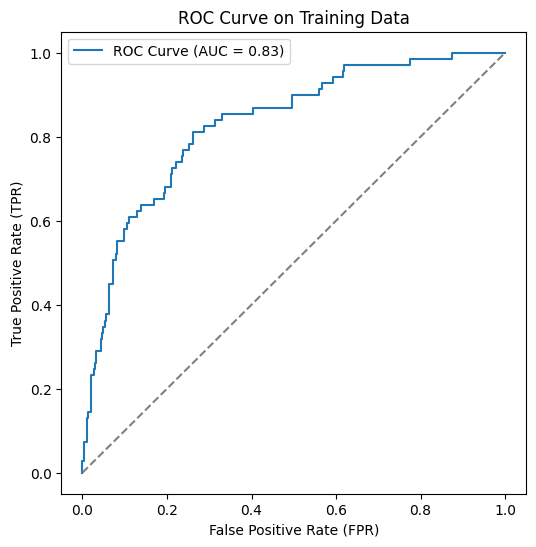

In [22]:
# Training Data Evaluation Metrics

# Predictions (discrete)
y_train_pred = best_model.predict(X_train)

print("Training Data Evaluation Metrics:")

# Confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
tn, fp, fn, tp = cm_train.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Precision & Recall
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

# Continuous scores for AUROC
if hasattr(best_model, "predict_proba"):
    y_scores = best_model.predict_proba(X_train)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_scores = best_model.decision_function(X_train)
else:
    y_scores = y_train_pred  # fallback (not ideal)

# AUROC
roc_auc = roc_auc_score(y_train, y_scores)
print(f"AUC-ROC Score: {roc_auc:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_train, y_scores)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Training Data")
plt.legend()
plt.show()

dropping 3158 columns total
Testing Data Evaluation Metrics:
True Positives (TP): 9
False Positives (FP): 24
True Negatives (TN): 52
False Negatives (FN): 8
Precision: 0.273
Recall: 0.529
dropping 3158 columns total
AUC-ROC Score: 0.6471


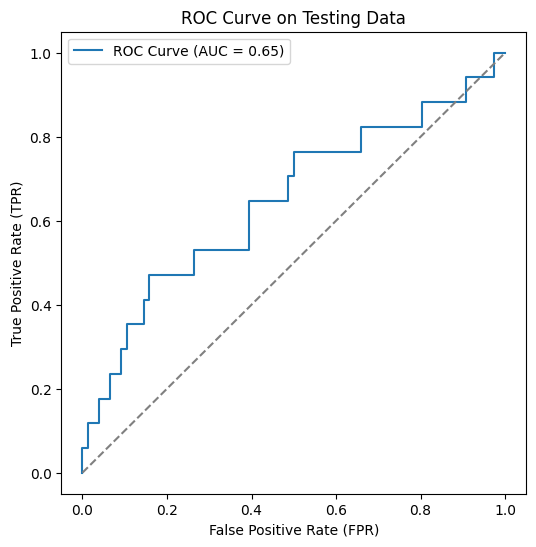

In [23]:
# Test Data Evaluation Metrics

# Predictions (discrete)
y_test_pred = best_model.predict(X_test)

print("Testing Data Evaluation Metrics:")

# Confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred)
tn, fp, fn, tp = cm_test.ravel()
print(f"True Positives (TP): {tp}")
print(f"False Positives (FP): {fp}")
print(f"True Negatives (TN): {tn}")
print(f"False Negatives (FN): {fn}")

# Precision & Recall
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

# Continuous scores for AUROC
if hasattr(best_model, "predict_proba"):
    y_scores = best_model.predict_proba(X_test)[:, 1]
elif hasattr(best_model, "decision_function"):
    y_scores = best_model.decision_function(X_test)
else:
    y_scores = y_test_pred  # fallback (not ideal)

# AUROC
roc_auc = roc_auc_score(y_test, y_scores)
print(f"AUC-ROC Score: {roc_auc:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, linestyle='-', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve on Testing Data")
plt.legend()
plt.show()

In [ ]:
# #Save the best estimator from GridSearchCV
# joblib.dump(best_model, "../models/LASSO_new_pipeline") # change the path depending on the model